# Comparing MC gradient estimators on probabilistic objectives

In [1]:
import torch
import matplotlib.pyplot as plt

from mc_estimators.measure_valued_gradient import MVD
from mc_estimators.reinforce_gradient import Reinforce
from mc_estimators.pathwise_gradient import Pathwise


# === EXPERIMENT PARAMETERS ===
seed = 4243254
episodes = 5000
episode_size = 100
learning_rate = 1e-3
optimizer_class = torch.optim.SGD
objective = lambda x: x**2
objective_derivative = lambda x: 2*x

torch.manual_seed(seed)

# Generate initial parameters
init_mean = torch.randn(1, requires_grad=False)
init_cov = 1


def train(estimator):
    mean = torch.nn.Linear(1, 1, bias=False)
    with torch.no_grad():
        mean.weight.copy_(init_mean.clone())
    
    optimizer = optimizer_class(mean.parameters(), lr=learning_rate)
    
    means = [init_mean]
    covs = [init_cov]
    
    x = torch.ones(1)
    for episode in range(episodes):
        optimizer.zero_grad()
        estimator((mean(x), init_cov)).backward()
        optimizer.step()
        
        with torch.no_grad():
            means.append(mean(x))
            covs.append(init_cov)
    
    return means, covs


estimators = {
    # Measure-Valued Gradient
    "MVD": MVD(objective, int((episode_size + 1) / 2), 1, coupled=False),
    # Log Gradient
    "REINFORCE": Reinforce(objective, episode_size, torch.distributions.Normal), 
    # Reparameterization-Trick Gradient
    "Pathwise": Pathwise(objective, episode_size, torch.distributions.Normal) 
}

# Train and save results
results = {name: train(estimator) 
           for i, (name, estimator) in enumerate(estimators.items())}

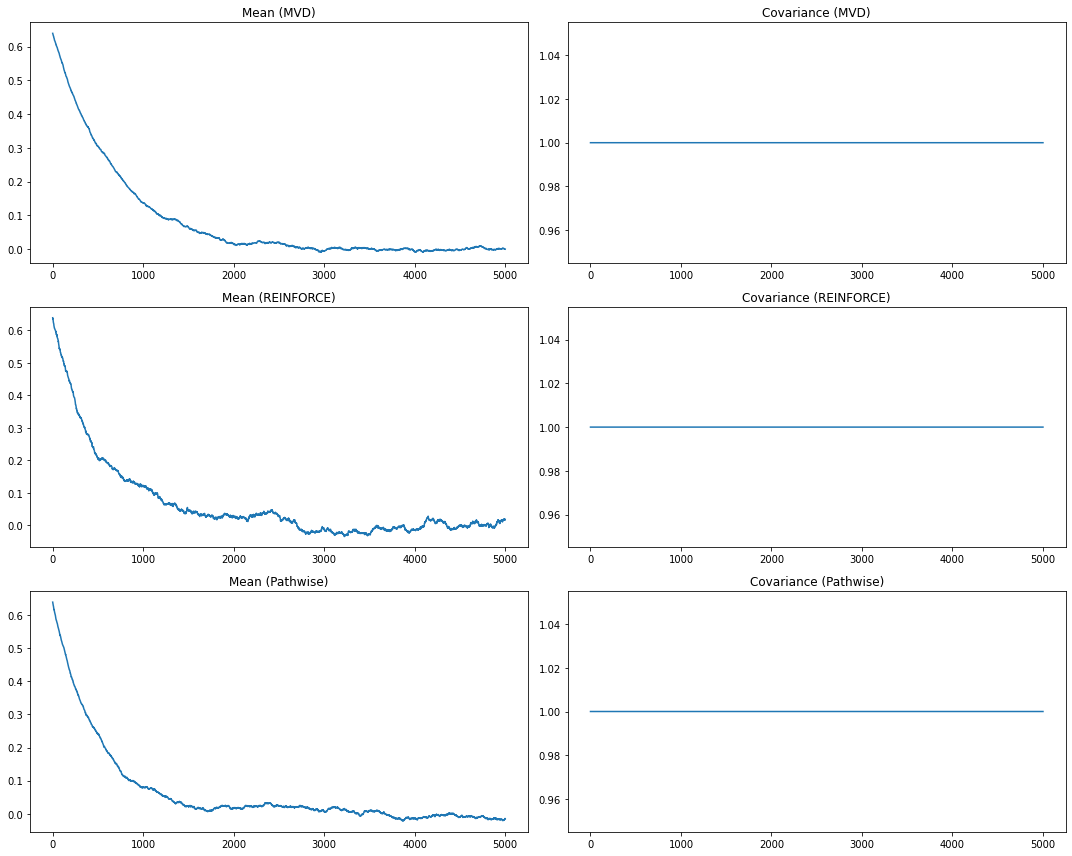

In [2]:
fig, axes = plt.subplots(nrows=len(results), ncols=2, figsize=(15, 4*len(results)))

for i, (name, (means, covs)) in enumerate(results.items()):
    axis = axes[i] if len(results) > 1 else axes
    axis[0].plot(means)
    axis[0].set_title(f'Mean ({name})')
    axis[1].plot(covs)
    axis[1].set_title(f'Covariance ({name})')

fig.tight_layout()
plt.show()